# 2 Augmentations

Now that we have cutouts, we can run the augmentation series on each galaxy:

1. Rescale the image to a different pixel scale
3. Re-measure the noise level as noise does not always scale as expected
4. Add noise to match a new surface brightness level

***

#### Imports

In [19]:
import sys
sys.path.append('../')

from lib.augmentations import *
from lib.utils import estimate_bg
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt 
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['patch.antialiased'] = False

## 1. Load the cutout

We've made the cutout in **01 Raw Data.ipynb** - now we load the file and all the relevant header informaiton.

Choose an example galaxy:

In [73]:
sample = pd.read_csv('../data/catalogs/sample.csv')
galaxy = 'gmp2364'
# galaxy = 'ngc1741'
row = sample[sample.galaxy == galaxy].iloc[0]

Open the cutout file

In [74]:
# Open the cutout file 
file = fits.open(f'../data/cutouts/{row.galaxy}.fits')
img = file['SCI'].data
err = file['ERR'].data
mask = file['MASK'].data > 0
exp = file['EXP'].data
bg_rms = file['BG_RMS'].data
header = file['SCI'].header
psf = file['PSF'].data

# Convert to counts
sky = (bg_rms*exp)**2
counts = img*exp + sky

# Header information
pxscale_og = row.pc_px
pxscale_og_arcsec = header['PXSCALE']
pc_per_arcsec = row.pc_px / pxscale_og_arcsec
zp = header['ZP']
z = row.z

## 2. Rescale the image

This is done with `rescale_image`. We choose a new physical scale (in parsec/pc) and use `skimage.transform.downscale_local_mean` to resample the image onto a new grid. We multiply the image by the downscale factor $^2$ to conserve total flux.

2. Generate a new Moffat PSF that would be 2-pixeln wide on the new chosen pixel scale.
3. Convolve the original image and the original PSF to get the new convolved image + the new effective PSF
    * Apply the mask in the convolution step so that masked pixels do not bleed out.
    * Convolve the image in image units (since counts are non-uniform across the mosaic), then convert to counts as it makes error propagation easier
5. Sample the Poisson distribution of the image again to mimic the Poisson noise post-convolution
6. Downscale the image (in electrons)
7. Calculate the new error array: square root of the dowsampled image
8. Also resample the sky and exptime maps to convert the image back to image units

In [77]:
pxscale_new_approx = 25
img_rescaled, err_rescaled, psf_rescaled, mask_rescaled, pxscale_new = rescale_image(
            img, counts, exp, sky, mask, pxscale_new_approx, pxscale_og, psf, 
            psf_size_px=2, imsize_min=20
)
pxscale_new_arcsec = pxscale_new / pc_per_arcsec

ZeroDivisionError: division by zero

Plot the new image compared to the original:

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_50770/1306033103.py:4: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(-2.5*np.log10(np.abs(img_rescaled)/pxscale_new_arcsec**2)+zp, vmin=17, vmax=30, cmap='gray_r')


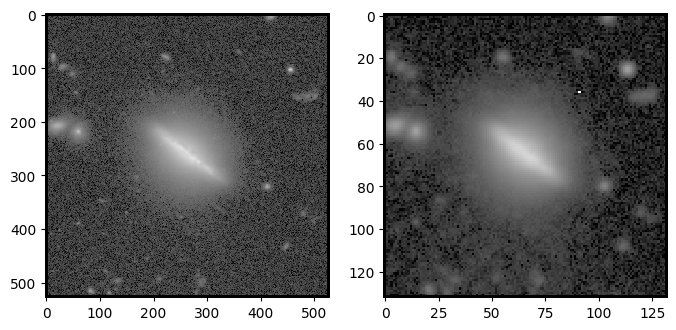

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(-2.5*np.log10(np.abs(img)/pxscale_og_arcsec**2)+zp, vmin=17, vmax=30, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_rescaled)/pxscale_new_arcsec**2)+zp, vmin=17, vmax=30, cmap='gray_r')

## Recalculate the background

With our new image, we can calculate the sky background level *again*, since the underlying sky is not actually random noise a new features often show up after the convolution+downsampling.

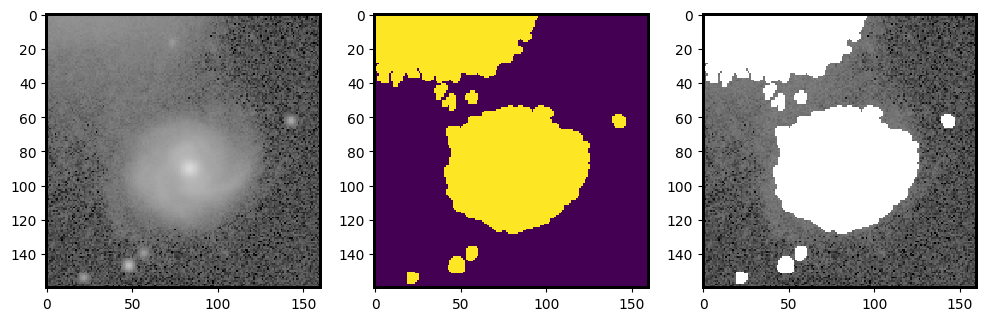

In [58]:
 _, _, bg_std, bg_mask, _ = estimate_bg(img_rescaled, mask_rescaled, mask_rescaled, filter_size=0, fit_bg=False, bg_sigma=2, grow_sigma=0.5)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(-2.5*np.log10(np.abs(img_rescaled)/pxscale_new_arcsec**2)+zp, vmin=17, vmax=30, cmap='gray_r')
axs[1].imshow(bg_mask)
axs[2].imshow(-2.5*np.log10(np.abs(np.ma.array(img_rescaled, mask=bg_mask))/pxscale_new_arcsec**2)+zp, vmin=17, vmax=30, cmap='gray_r')

## 3. Add noise

Now, given a chosen surface brightness threshold $\mu^{\rm{new}}$, we add noise to match that surface brightness. We use our re-calculated background RMS from the previous step, $\sigma$, and add an ammount of white noise with standard deviation $\sigma'$ given by 


\begin{equation}
    \sigma'^2 = \sigma^2 \left( 10^{\frac{2\left(\mu_\sigma^{\rm{new}} - \mu_\sigma^{\rm{og}}\right)}{2.5}} - 1 \right)
\end{equation}


In [59]:
sblim_new = 21.5
img_noisy, err_noisy = add_noise(img_rescaled, err_rescaled, sblim_new, bg_std, pxscale_new_arcsec, zp)

Check that the background level is what we expect:

In [60]:
_, _, bg_std_new, _, _ = estimate_bg(img_noisy, mask_rescaled, mask_rescaled, filter_size=0, fit_bg=False, bg_sigma=2, grow_sigma=0.5)
print('New SB limit', -2.5*np.log10(bg_std_new/pxscale_new_arcsec**2)+zp)

New SB limit 21.488095736279554


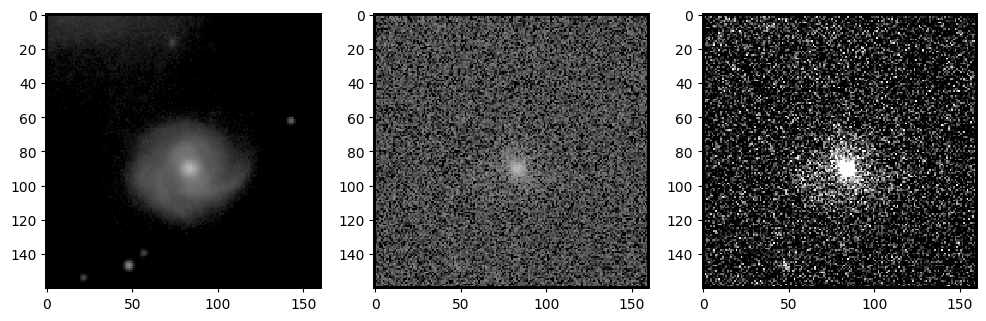

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(-2.5*np.log10(np.abs(img_rescaled)/pxscale_new_arcsec**2)+zp, vmin=17, vmax=24, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(img_noisy)/pxscale_new_arcsec**2)+zp, vmin=17, vmax=24, cmap='gray_r')
axs[2].imshow(img_noisy/err_noisy, vmin=0, vmax=3, cmap='gray')